In [43]:
import networkx as nx
import matplotlib.pyplot as plt
import ot

from functions import *
from noisy_graphs import *
from sample_graphs import *
from frank_wolfe import *
from grampa import *
from eigenalign import *
from isorank import *

In [44]:
#G = nx.read_edgelist('./graphs/collaboration_astrophysics')
#A = nx.adjacency_matrix(G).todense()
#print("Number of nodes:", G.number_of_nodes())
#print("Number of edges:", G.number_of_edges())

In [45]:
#Gprime = nx.Graph.copy(G)
#B = nx.adjacency_matrix(Gprime)

# now run your algorithm on (G, Gprime) or on (A, B) !
#print("Number of nodes:", G.number_of_nodes())
#print("Number of edges:", G.number_of_edges())

In [46]:
# G and Gprime are too big (in memory) for computation
# new dataset

n = (20)
p = 0.4

A_eq, b_eq =  bistochastic_equality_constraints(n)

G0, A0 = sample_Erdos_Renyi(n, p)
G1, A1 = sample_Erdos_Renyi(n, p)

Ps = rand_perm_matrix(n)


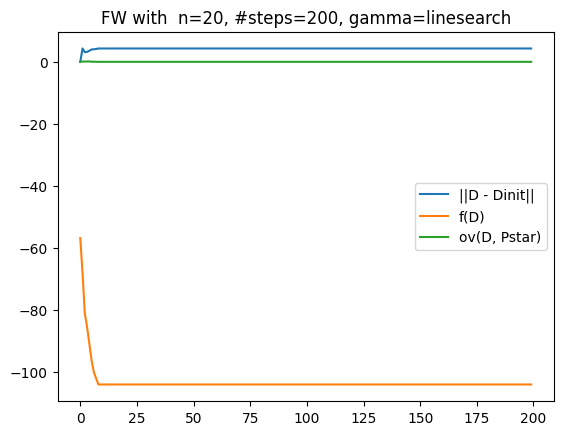

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.

In [47]:
#Frank_wolfe algorithm

D = frank_wolfe(A0, A1, 200, Pstar=Ps , method="minustrace",plot=True)
print(D)
# minustrace more efficient than mindiff ??

9.695359714832659


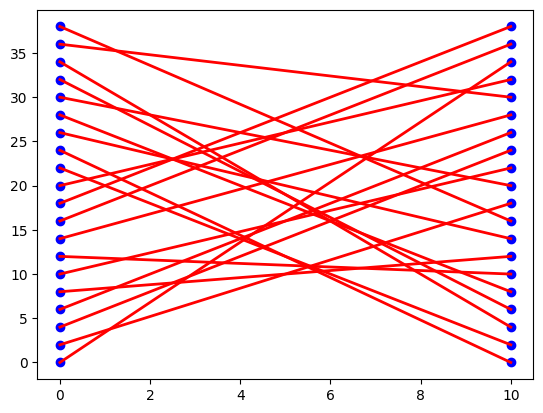

In [48]:
Dp = project_to_perm(D, A_eq, b_eq)

# we want to see how Dp appair these two graphs
plot_alignment(G0, G1, D)
print(np.linalg.norm(A0.toarray() - D @ A1.toarray() @ D.T))

9.695359714832659


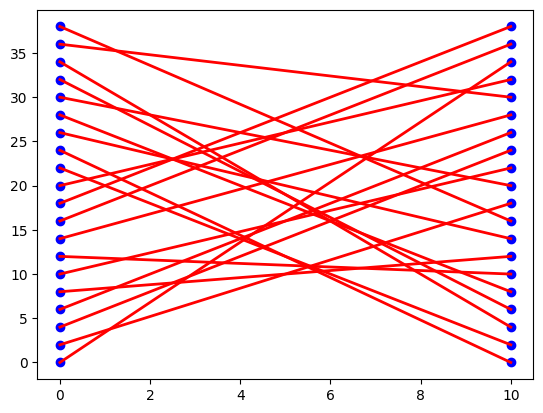

In [49]:
plot_alignment(G0,G1, Dp)
print(np.linalg.norm(A0.toarray() - Dp @ A1.toarray() @ Dp.T))

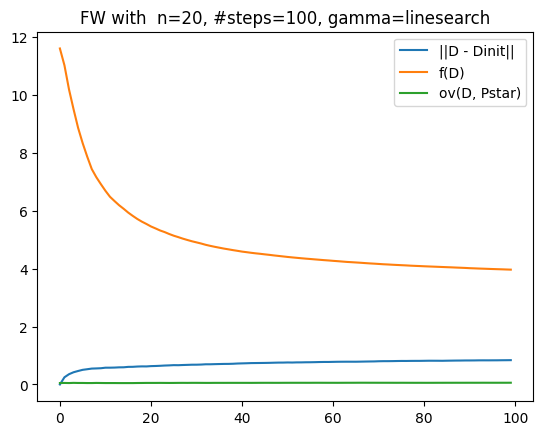

In [50]:
D1 = frank_wolfe(A0, A1, 100, Pstar=Ps , method="mindiff",plot=True)


9.2468069400069


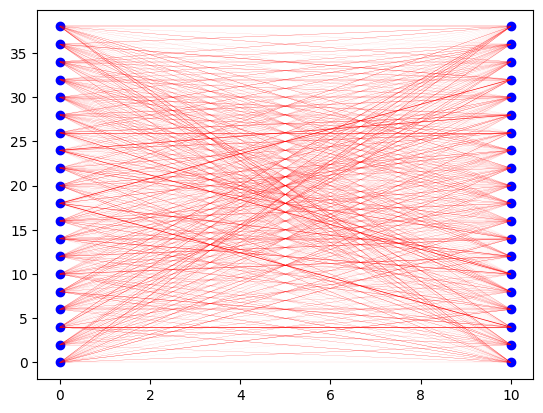

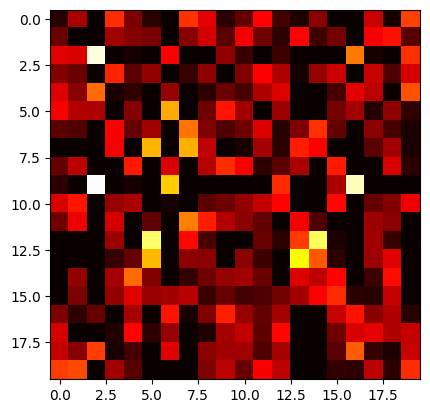

In [51]:
D1p = project_to_perm(D1, A_eq, b_eq)

# we want to see how Dp appair these two graphs
plot_alignment(G0, G1, D1)
print(np.linalg.norm(A0.toarray() - D1 @ A1.toarray() @ D1.T))
plt.show()
matrix_heatmap(D1)

11.74734012447073


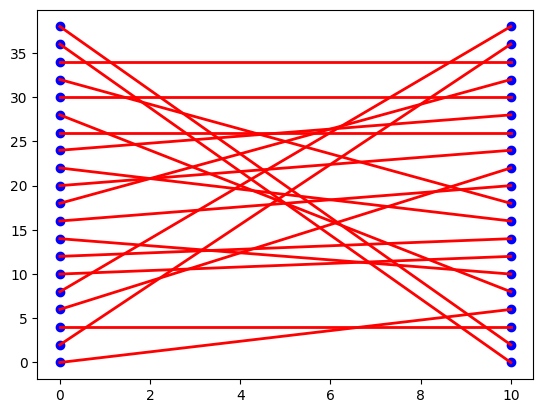

In [52]:
plot_alignment(G0, G1, D1p)
print(np.linalg.norm(A0.toarray() - D1p @ A1.toarray() @ D1p.T))

13.19090595827292


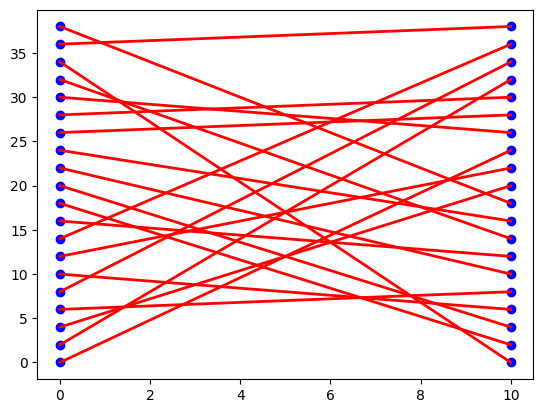

In [53]:
#GRAMPA ?

eta = 0.1
D2 = grampa(A0.toarray(), A1.toarray(), eta)
plot_alignment(G0, G1, D2)
print(np.linalg.norm(A0.toarray() - D2 @ A1.toarray() @ D2.T))

In [54]:
EigP = eigenalign(G0, G1, 1, 0, 0)

13.19090595827292
0.05


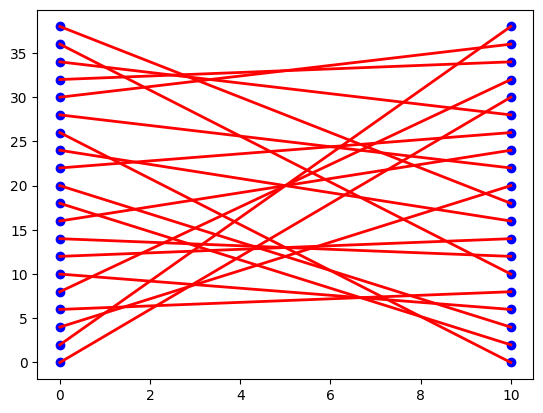

In [55]:
plot_alignment(G0, G1, EigP)
print(np.linalg.norm(A0.toarray() - EigP @ A1.toarray() @ EigP.T))
print(overlap(EigP, D1p))


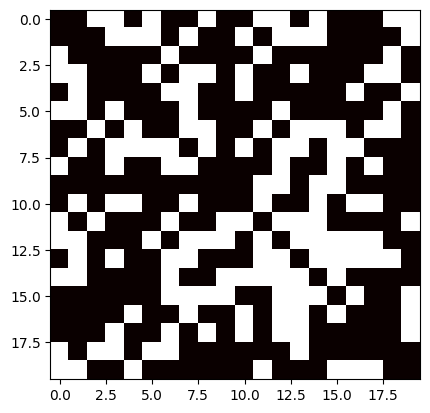

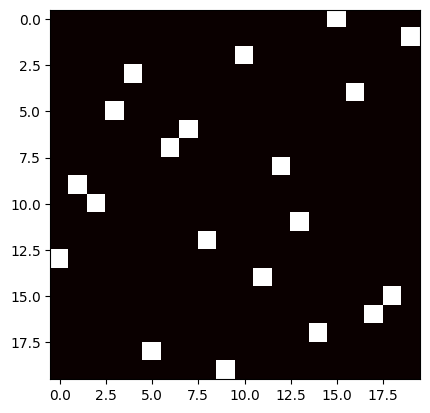

In [56]:
matrix_heatmap(A0.toarray())
plt.plot()
matrix_heatmap(EigP)

13.490737563232042
0.1


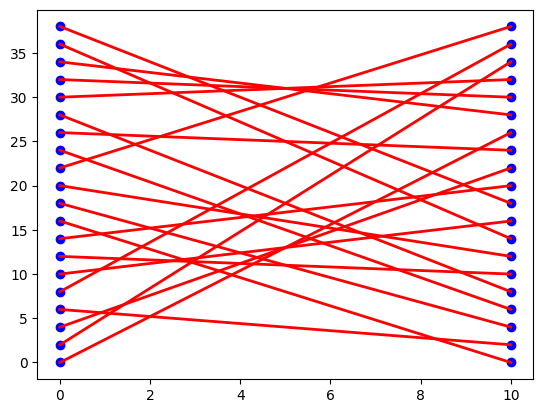

In [57]:
isor = isorank(G0, G1)
plot_alignment(G0, G1, isor)

print(np.linalg.norm(A0.toarray() - isor @ A1.toarray() @ isor.T))
print(overlap(isor, EigP))



9.695359714832659
0.05


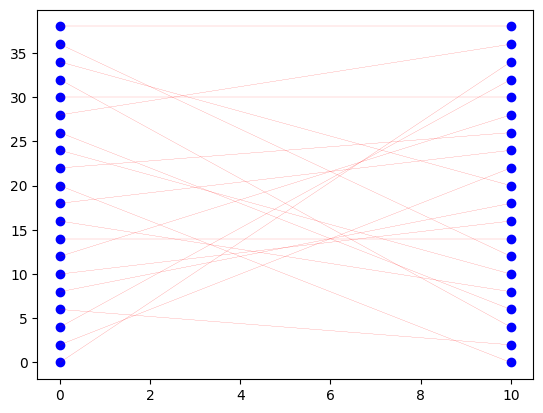

In [58]:
A0 = (A0).astype(float)
A1 = (A1).astype(float)
T = ot.gromov.gromov_wasserstein(A0.toarray(), A1.toarray(), loss_fun='square_loss')
plot_alignment(G0, G1, T)
plt.plot()
Tp = project_to_perm(T, A_eq, b_eq)
print(np.linalg.norm(A0.toarray() - Tp @ A1.toarray() @ Tp.T))
print(overlap(Tp, Dp))

In [59]:
T = greedy_to_perm(T)
print(np.linalg.norm(A0.toarray() - T @ A1.toarray() @ T.T))
print(overlap(T, Dp))

9.695359714832659
0.05
